In [1]:
import pandas as pd 
import numpy as np
import os 
import json
from math import ceil, floor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2

from sklearn.preprocessing import LabelEncoder,scale
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.utils.multiclass import unique_labels

from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})

import re
import nltk
from nltk.corpus import stopwords


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, Dropout, GlobalMaxPooling1D,MaxPooling1D,LSTM
from keras.metrics import categorical_accuracy
from keras.callbacks import  EarlyStopping


Using TensorFlow backend.


In [2]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
Number_RE = re.compile('[*^0-9]')
Bad_underline = re.compile('[*_*]')
RemoveTag = re.compile('&lt;|br&gt;|b&gt;|ul&gt;|li&gt;')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = RemoveTag.sub('',text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = Number_RE.sub(' ', text) # replace Number symbols by space in text
    text = Bad_underline.sub(' ', text) # replace Underline symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
RemoveLastSpace = re.compile(' $')

def clean_text_category(text):
    text = RemoveLastSpace.sub('',text)
    return text
    

In [3]:
def classNumberThreshold(arr):
    dropCategory = []

    for key,value in arr.items():
        if(value<=30):
            dropCategory.append(key)
    return dropCategory

In [4]:
df = pd.read_csv('../../example/combine.csv')

In [5]:
def checkNanin(text):
    text = str(text)
    if(text=="nan"):
        return ""
    else:
        return text
df.description = df.description.apply(checkNanin)  
df.description = df['description'].apply(clean_text)
df = df[pd.notnull(df['category'])]
df = df[pd.notnull(df['uniq_id'])]
df = df[pd.notnull(df['description'])]
df = df.dropna(subset=['description'])


In [6]:
dropCategoryCode  = classNumberThreshold(df.category.value_counts())
dropSubCategoryCode  = classNumberThreshold(df.subcategory.value_counts())

for i in dropCategoryCode:
    df = df[df.category!=i]
    
for i in dropSubCategoryCode:
    df = df[df.subcategory!=i]




In [7]:
le = LabelEncoder()
le.fit(df.category)
target = le.classes_
labels = le.transform(df.category)

le.fit(df.subcategory)
subtarget = le.classes_
sublabels = le.transform(df.subcategory)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28540 entries, 0 to 28689
Data columns (total 8 columns):
uniq_id          28540 non-null object
product_name     28540 non-null object
description      28540 non-null object
category_main    27101 non-null object
category_sub1    27101 non-null object
category_sub2    23396 non-null object
category         28540 non-null int64
subcategory      28540 non-null int64
dtypes: int64(2), object(6)
memory usage: 2.0+ MB


In [9]:
embedding_dim = 300 # We use 100 dimensional glove vectors
glove_dir = '../../glove.6B' # This is the folder with the dataset
embeddings_index = {} # We create a dictionary of word -> embedding
with open(os.path.join(glove_dir, 'glove.6B.300d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0] # The first value is the word, the rest are the values of the embedding
        embedding = np.asarray(values[1:], dtype='float32') # Load embedding
        embeddings_index[word] = embedding # Add embedding to our embedding dictionary
    print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))

Found 400,000 word vectors in GloVe.


In [10]:
X_train, X_test, y_train_info, y_test_info = train_test_split(df.description, pd.DataFrame({'index':df.index, 'label':labels}), 
                                                    test_size=0.1, random_state = 27)

In [11]:
y_train = y_train_info.label
y_test = y_test_info.label


In [12]:
tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df.description)
vocab_size = len(tfidfconverter.get_feature_names())


In [13]:
def tokenizer_and_pad_sequence (Xtrain,Xtest,vocab_size,embeddings_index):
    tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
    tokenizer.fit_on_texts(Xtrain)
    
    sequences = tokenizer.texts_to_sequences(Xtrain)
    sequences_test = tokenizer.texts_to_sequences(Xtest)
    
    trainlengths = [len(ele) for ele in sequences]
    testlengths = [len(ele) for ele in sequences_test]
    max_length = min(max(trainlengths),max(testlengths))
    
    
    
    word_index = tokenizer.word_index
    embedding_dim = 300
    nb_words = min(vocab_size, len(word_index)) # How many words are there actually
    embedding_matrix = np.zeros((nb_words, embedding_dim))
    # The vectors need to be in the same position as their index. 
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    # Loop over all words in the word index
    for word, i in word_index.items():
        # If we are above the amount of words we want to use we do nothing
        if i >= vocab_size: 
            continue
        # Get the embedding vector for the word
        embedding_vector = embeddings_index.get(word)
        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    return sequences,sequences_test,max_length, embedding_matrix

def model_settings(length,vocabSize,embeddingMatrix,outputnum):
        embedding_dim = 300
        model = Sequential()
        model.add(Embedding(vocab_size, embedding_dim, input_length=length, weights = [embedding_matrix], 
                                trainable = False))
        model.add(Conv1D(200,3,padding='valid',activation='relu',strides=1))        
        # we use max pooling:
        model.add(GlobalMaxPooling1D())
        # We add a vanilla hidden layer:
        model.add(Dense(250))
        model.add(Dropout(0.2))
        model.add(Dense(outputnum, activation='softmax'))
        model.summary()
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
        return model
def model_settings2(length,vocabSize,embeddingMatrix,outputnum):
        embedding_dim = 300
        model = Sequential()
        model.add(Embedding(vocabSize, embedding_dim, input_length=length, weights = [embeddingMatrix], 
                                trainable = False))
        model.add(Dropout(0.25))
        model.add(Conv1D(128,5,padding='valid',activation='relu',strides=1))        
        # we use max pooling:
        model.add(MaxPooling1D(4))
        model.add(LSTM(70))
        model.add(Dropout(0.2))
        model.add(Dense(outputnum, activation='softmax'))
        model.summary()
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
        return model

In [14]:
categoricalLabel = to_categorical(y_train)
categoricalTestLabel = to_categorical(y_test)

EPOCHS = 10
BATCH_SIZE = 100

#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)


sequences,sequences_test,max_length, embedding_matrix =  tokenizer_and_pad_sequence(X_train,X_test, vocab_size, embeddings_index)

Scores = []
Models = []
Scores2 = []
Models2 = []
Scores3 = []
Models3 = []
Lengths = [ele for ele in range(50, max_length, 100)]
for ele in range(50, max_length, 100):
    
    train = pad_sequences(sequences,maxlen= ele)
    test = pad_sequences(sequences_test,maxlen = ele)
    
    model = model_settings(ele, vocab_size, embedding_matrix, len(np.unique(y_train)))
    model2 = model_settings2(ele, vocab_size, embedding_matrix, len(np.unique(y_train)))
    model.fit(train, categoricalLabel, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping],  
                   verbose=1, validation_split=0.1)
    model2.fit(train, categoricalLabel, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping],  
                   verbose=1, validation_split=0.1)
    
    loss, score = model.evaluate(test, categoricalTestLabel, batch_size=BATCH_SIZE)
    loss2, score2 = model2.evaluate(test, categoricalTestLabel, batch_size=BATCH_SIZE)

    Scores.append(score)
    Models.append(model)
    Scores2.append(score2)
    Models2.append(model2)    
    
bestModelIndex = np.argmax(Scores)
bestLength = Lengths[bestModelIndex]
bestModel = Models[bestModelIndex]

bestModelIndex2 = np.argmax(Scores2)
bestLength2 = Lengths[bestModelIndex2]
bestModel2 = Models2[bestModelIndex2]


# save the model to disk
filename = 'Combine/'+str(bestLength)+'BestCNNs.sav'
joblib.dump(bestModel, filename)


W0803 12:50:47.095984 4634625472 deprecation_wrapper.py:119] From /Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 12:50:47.178271 4634625472 deprecation_wrapper.py:119] From /Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 12:50:47.182832 4634625472 deprecation_wrapper.py:119] From /Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 12:50:47.203525 4634625472 deprecation_wrapper.py:119] From /Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           3333900   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 200)           180200    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               50250     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 2259      
Total params: 3,566,609
Trainable params: 232,709
Non-trainable params: 3,333,900
____________________________________________________________

W0803 12:50:47.900646 4634625472 deprecation_wrapper.py:119] From /Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           3333900   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 128)           192128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                55720     
_________________________________________________________________
dropout_3 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 639       
Total para

Epoch 3/10
23117/23117 [==============================] - 115s 5ms/step - loss: 0.0270 - categorical_accuracy: 0.9613 - val_loss: 0.0267 - val_categorical_accuracy: 0.9654
Epoch 4/10
23117/23117 [==============================] - 125s 5ms/step - loss: 0.0204 - categorical_accuracy: 0.9726 - val_loss: 0.0250 - val_categorical_accuracy: 0.9661
Epoch 5/10
23117/23117 [==============================] - 125s 5ms/step - loss: 0.0173 - categorical_accuracy: 0.9763 - val_loss: 0.0282 - val_categorical_accuracy: 0.9595
Epoch 6/10
23117/23117 [==============================] - 130s 6ms/step - loss: 0.0144 - categorical_accuracy: 0.9801 - val_loss: 0.0243 - val_categorical_accuracy: 0.9661
Epoch 7/10
23117/23117 [==============================] - 124s 5ms/step - loss: 0.0122 - categorical_accuracy: 0.9835 - val_loss: 0.0250 - val_categorical_accuracy: 0.9692
Epoch 8/10
23117/23117 [==============================] - 122s 5ms/step - loss: 0.0104 - categorical_accuracy: 0.9855 - val_loss: 0.0268 - v

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 350, 300)          3333900   
_________________________________________________________________
dropout_11 (Dropout)         (None, 350, 300)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 346, 128)          192128    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 86, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 70)                55720     
_________________________________________________________________
dropout_12 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 639       
Total para

23117/23117 [==============================] - 167s 7ms/step - loss: 0.0365 - categorical_accuracy: 0.9476 - val_loss: 0.0319 - val_categorical_accuracy: 0.9556
Epoch 3/10
23117/23117 [==============================] - 186s 8ms/step - loss: 0.0260 - categorical_accuracy: 0.9636 - val_loss: 0.0288 - val_categorical_accuracy: 0.9591
Epoch 4/10
23117/23117 [==============================] - 181s 8ms/step - loss: 0.0223 - categorical_accuracy: 0.9686 - val_loss: 0.0266 - val_categorical_accuracy: 0.9615
Epoch 5/10
23117/23117 [==============================] - 193s 8ms/step - loss: 0.0167 - categorical_accuracy: 0.9768 - val_loss: 0.0262 - val_categorical_accuracy: 0.9681
Epoch 6/10
23117/23117 [==============================] - 190s 8ms/step - loss: 0.0152 - categorical_accuracy: 0.9784 - val_loss: 0.0242 - val_categorical_accuracy: 0.9696
Epoch 7/10
23117/23117 [==============================] - 173s 7ms/step - loss: 0.0129 - categorical_accuracy: 0.9817 - val_loss: 0.0238 - val_categori

NameError: name 'bestMode2' is not defined

In [16]:
filename2 = 'Combine/'+str(bestLength2)+'BestLayerCNNswithLSTM.sav'
joblib.dump(bestModel2, filename2)

['Combine/450BestLayerCNNswithLSTM.sav']

In [17]:
test = pad_sequences(sequences_test,maxlen = bestLength)
yConfidence = bestModel.predict(test)
yPred = [ np.argmax(ele) for ele in yConfidence ]

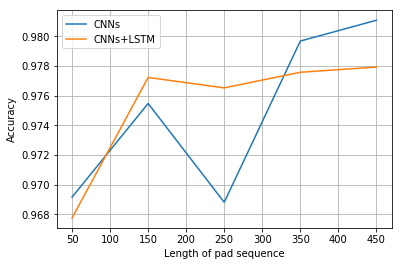

In [18]:
fig,ax  = plt.subplots()
ax.plot(Lengths,Scores,label="CNNs")
ax.plot(Lengths,Scores2,label="CNNs+LSTM")

ax.set_xlabel("Length of pad sequence")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.savefig("Combine/CNNsbestsequenceLength.png")

In [19]:
target = [ str(ele) for ele in target]
subtarget = [ str(ele) for ele in subtarget]


totalConfidenceSize = yConfidence.shape[0]*yConfidence.shape[1]
Confidence1DArr = yConfidence.reshape(totalConfidenceSize,1)
Max = ceil(max(Confidence1DArr)[0])
Min = floor(min(Confidence1DArr)[0])
NormalisedConfid = [round((max(ele)-Min)/(Max-Min),2) for ele in yConfidence]
productID = [ df[df.index==ele]['uniq_id'].values[0] for ele in y_test_info['index'] ]
ProductDescription =[ df[df.index==ele]['description'].values[0] for ele in y_test_info['index'] ]
CNNResult = pd.DataFrame({'id':productID,'description':ProductDescription,
                         'trueClass': y_test,'trueClassNaem':[target[e] for e in y_test],
                         'predictClass':yPred,'predictClassName':[target[e] for e in yPred],
                         'Confidence':NormalisedConfid})
CNNResult.to_csv("Combine/CNNResults.csv",index=False,compression=None)

In [20]:
def draw_confidenceReport(data):
    num = [ ele*0.01 for ele in range(20,81,2)]
    totalitems = []
    correct = []
    incorrect = []
    for ele in num:
        Threshold = data[data['Confidence']>ele]
        correct.append(len(Threshold[Threshold['trueClass']==Threshold['predictClass']].index))
        incorrect.append(len(Threshold[Threshold['trueClass']!=Threshold['predictClass']].index))
        totalitems.append(len(Threshold.index))
    
    ClassfiedProportion = [ ele/len(data.index) for ele in totalitems]
    
    Acc =[]
    for ele in zip(correct,totalitems):
        if (ele[1]==0):
            Acc.append(0)
        else:
            Acc.append(ele[0]/ele[1])

    fig,ax  = plt.subplots()
    
    color = 'tab:blue'
    ax.scatter(num,ClassfiedProportion,label="Proportion classified",color=color)
    ax.set_xlabel("Confidence Score")
    ax.set_ylabel("Proportion classified", color=color)
    ax.xaxis.set_ticks(np.arange(0,1.1,0.1))
    ax.yaxis.set_ticks(np.arange(0,1.1,0.1))
    ax.tick_params(axis='y', labelcolor=color)

    color = 'tab:red'

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.scatter(num,Acc,label="Accuracy", color=color)
    ax2.set_ylabel("Accuracy", color=color)
    ax2.yaxis.set_ticks(np.arange(0,1.1,0.1))
    ax2.tick_params(axis='y', labelcolor=color)

    ax.grid()
    fig.savefig("Combine/ConfidenceScoreReportCNN.png")

In [21]:
print(classification_report(y_test, yPred,target_names=target))
with open('Combine/CNNReport.txt', 'w') as file:
    file.write(classification_report(y_test, yPred,target_names=target))

              precision    recall  f1-score   support

      100000       0.97      0.98      0.97        89
      110000       0.80      0.74      0.77        38
      200000       1.00      0.89      0.94        45
      300000       1.00      0.92      0.96        77
      400000       0.95      1.00      0.97       160
      500000       1.00      0.99      0.99      1276
      700000       0.97      0.98      0.98       313
      800000       0.97      0.99      0.98       829
      900000       0.96      0.93      0.94        27

   micro avg       0.98      0.98      0.98      2854
   macro avg       0.96      0.93      0.95      2854
weighted avg       0.98      0.98      0.98      2854



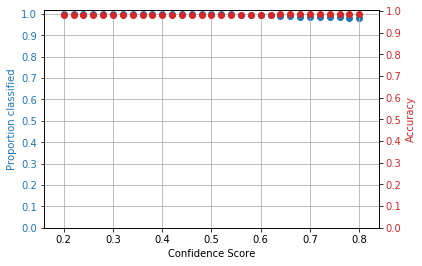

In [22]:
draw_confidenceReport(CNNResult)

In [23]:
cm = confusion_matrix(y_test, yPred)

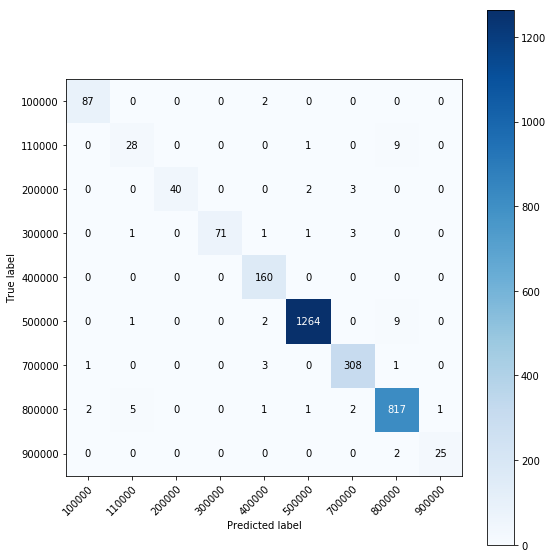

In [24]:
fig, ax = plt.subplots(figsize=(8,8))
im =ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
classes = target
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,ylabel='True label',xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
fig.savefig("Combine/CNNConfusionMatrix.png")